# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2024

Côté, Gabriel, 2082508

Tourigny, François, 2079718

Note finale:

<u>**Date limite de remise :**</u>  4 décembre 23h59 pour les deux groupes

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Le problème qu'on vous demande de résoudre cette fois-ci est un peu plus difficile. Vous êtes responsable de la séparation des voteurs d'un pays en circonscriptions. Un des deux candidats principaux, M. T, vient vous voir et vous demande de lui garantir une victoire (pour un montant non négligeable d'argent). Évidemment, vous refusez, mais le problème est intéressant et vous décidez d'essayez de le résoudre. Si ça vous intéresse, ce problème est ce qu'on appelle du *gerrymandering*.

Vous aurez comme entrée à votre problème une carte du pays (représentée par une matrice carrée $n \times n$) qui contient à chaque position le nombre de voteurs pour candidat X (un chiffre entre 0 et 1000). Votre objectif est de créer $n$ circonscriptions de sorte à ce que candidat X gagne l'élection. Quelques spécifications importantes:

- La variable $n$ représente un côté de la matrice. Il y a donc, $n^2$ villes.
- Chaque position de la matrice représente une ville
- Chaque circonscription doit contenir **$n$ villes**. Une solution reste valide si une circonscription ne contient pas exactement $n$ villes, mais il y a une **pénalité** qui y est associée.
- Les villes d'une circonscription doivent être proche les unes des autres. On aimerait garder cette **distance à, au plus, $n/2$**. Encore une fois, on permet de briser cette contrainte, mais il y aura une pénalité qui y est associée. (**Distance manhattan**)
- Les villes d'une circonscription ne doivent **pas être nécessairement voisines** tant qu'on respecte la distance maximale. Voir l'exemple plus bas.
- Le candidat remporte une circonscription si le nombre de voteurs dans cette circonscription est supérieur à $500n$.
- Le candidat cherche à remporter le plus de circonscriptions qu'il peut.

![alt text](distance_example.png)


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une matrice carrée de taille $n$ contenant des nombres entre $1$ et $1000$. Vous pouvez utilisez des exemplaires aléatoires pour tester votre code. La compétition sera faite sur les mêmes exemplaires de tailles différentes pour toutes les équipes d'un même groupe.

In [1]:
import random
from collections.abc import Iterable

def generate_city() -> int:
    return round(min(1000,max(0,random.normalvariate(450,200))))

class Problem():
    def __init__(self, size: int, num_samples: int = 5) -> None:
        self.size = size
        self.num_samples = num_samples

    def generate_sample(self) -> list[list[int]]:
        """Returns a matrix containing values between 0 and 1000. Each value is the number of voters in a given city"""
        return [[generate_city() for _ in range(self.size)] for _ in range(self.size)]

    def generate_dataset(self) -> Iterable[list[list[int]]]:
        """Returns an iterator over as many samples as are described"""
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [2]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import ceil
import math
from scipy.stats import linregress
import numpy as np
from tqdm import trange

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def score_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Returns the score of the current solution. The score function is a penalty that must be minimized."""
    return votes_score(original, solution) + size_score(solution) + distance_score(solution)

def votes_score(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to lost districts. 
    It is 5 times the square of the number of lost districts."""
    lost_districts = 0
    for district in solution:
        sum = 0
        for city in district:
            sum += original[city[0]][city[1]]
        if sum <= 500*len(district):
            lost_districts += 1
    return 5 * lost_districts**2

def size_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to districts having the wrong size.
    It is the square of the difference between the wanted number of cities and the 
    current number of cities in a given district."""
    n = len(solution)
    size_penality = 0
    for district in solution:
        size_penality += (len(district)-n)**2
    return size_penality

def distance_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to the distance between cities in a district.
    It is the mean square distance between each city and every other city in its district."""
    distance_score = 0
    n = len(solution)
    for district in solution:
        for i,city in enumerate(district):
            for j in range(i+1, len(district)):
                distance_score += (max(0, distance_manhattan(city, district[j])-ceil(n/2)))**2
    return distance_score/len(solution)

def distance_manhattan(city_a: tuple[int,int], city_b: tuple[int,int]) -> int:
    return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

def is_valid_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> bool:
    """Validates solution"""
    n = len(original)

    if len(solution) != n:
        print(f"The solution does not contain {n} districts.")
        return False

    for district in solution:
        if len(district) < 1:
            print("The solution contains empty districts.")
            return False
        for city in district:
            if len(city)!=2:
                print("Solution must contain 2 coordinates per city.")
                return False
        for coord in city:
            if coord < 0 or coord >=n:
                print(f"City coordinates must below {n} and positive.")
                return False

    coord_set = set()
    for district in solution:
        for city in district:
            coord_set.add(city)
    if len(coord_set) != n*n:
        print(f"Solution contained {len(coord_set)} different cities while there should be {n*n} cities in the solution.")
        return False

    # Solution is valid
    return True

def make_problems(sizes: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    return [Problem(size,num_samples) for size in sizes]

def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
    """Returns a tuple containing the time as well as the score of the solution, in that order.
    
    Parameters:
        time_scale: Controls the level of precision of the time measurements.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return (round(end - start), score_solution(sample, solution))

def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns a Measure 
    instance representing the result as well as the problem.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(result[0] for result in results) / prob.num_samples
    mean_score = sum(result[1] for result in results) / prob.num_samples
    return Measure(prob.size, mean_time, mean_score)

def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken for each problem in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time and the score.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.mean, measure.mean_score))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

# Algorithme

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

In [3]:
class County():
    def __init__(self, row: int, col: int, pos: int, voters: int) -> None:
        self.row = row
        self.col = col
        self.pos = pos
        self.voters = voters
        self.neighbors = []
        self.group = -1

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def get_neighbours(self):
        return self.neighbors
    
    def set_group(self, group: int):
        self.group = group
    
    def get_group(self):
        return self.group
    
    def is_in_group(self):
        return self.group != -1


In [4]:
def get_neighbours_idx(idx, n):
    neighbours = []
    if idx - n > 0:
        neighbours.append(idx-n)
    if idx + n < n**2:
        neighbours.append(idx+n)
    if idx // n == (idx-1) // n:
        neighbours.append(idx-1)
    if idx // n == (idx+1) // n:
        neighbours.append(idx+1)
    return neighbours

def set_counties(sample) -> list[County]:
    n = len(sample)
    counties = [County(i, j, i*n+j, county) for i, line in enumerate(sample) for j, county in enumerate(line)]
    for county in counties:
        for neighbor_idx in get_neighbours_idx(county.pos, n):
            county.add_neighbor(counties[neighbor_idx])
    return counties


In [5]:
def distance(county_row, county_col, center_row, center_col, n):
    return (abs(center_row - county_row) + abs(center_col - county_col))
    
def max_to_target(counties: list[County], target: int, n: int):
    solution = []
    counties_available = counties
    groups = []
    groups_center = []
    center_row = 0
    center_col = 0
    for group_id in trange(n):
        new_group = []
        number_items = 0
        center_row = 0
        center_col = 0
        group_neighbors = []
        while len(new_group) < n:
            selection = None
            if len(group_neighbors) == 0:
                selection = max(counties_available, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
            elif sum(county.voters for county in new_group) < target:
                selection = max(group_neighbors, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
                #selection = random.choice(group_neighbors)
            else:
                selection = min(group_neighbors, key=lambda county: county.voters/n + distance(county.row, county.col, center_row, center_col, n)**2/n)

            new_group.append(selection)
            center_row = (center_row * number_items + selection.row) / (number_items + 1)
            center_col = (center_col * number_items + selection.col) / (number_items + 1)
            number_items += 1
            selection.set_group(group_id)
            
            group_neighbors.extend([neighbor for neighbor in selection.neighbors if not neighbor.is_in_group() and not neighbor in group_neighbors])
            counties_available.remove(selection)
            if selection in group_neighbors:
                group_neighbors.remove(selection)
            
        groups.append(new_group)
        groups_center.append((center_row, center_col))
        solution.append([(county.row, county.col) for county in new_group])
    return solution, groups



In [6]:

def main(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    print('improvement')
    while(True):
        updated = amelioration_locale(groups, target, n, sample, sol)
        sol = updated

        if (time.time() - start_time) > max_time - time_to_iter:
            return sol
        if(first_iter):
            first_iter = False
            time_to_iter = (time.time() - iter_time)

    #print(" ---------------- AFTER UPDATE -----------------")
    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('total score: ', score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol


def amelioration_locale(divisions, target, n, sample, sol):
    #init_score = score_solution(sample, sol)
    div_votes = [sum(county.voters for county in div) for div in divisions]
    groups_center = [(sum(county.row for county in div)/n, sum(county.col for county in div)/n) for div in divisions]

    #selected_div_idx = div_votes.index(max(div for div in div_votes if div < target))
    #selected_div_idx = divisions.index(random.choice([div for div in divisions if sum(county.voters for county in div) < target]))
    selected_div_idx = divisions.index(random.choice(divisions))
    #selected_div_idx = div_votes.index(min(div_votes))

    selected_div = divisions[selected_div_idx]
    center_swap_group_row = groups_center[selected_div_idx][0]
    center_swap_group_col = groups_center[selected_div_idx][1]

    modified_selected_div = [county.voters + distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n) for county in selected_div]
    county_to_swap_idx = modified_selected_div.index(min(modified_selected_div))
    county_to_swap = divisions[selected_div_idx][county_to_swap_idx]
    #print('county to swap: ', county_to_swap.pos)
    differential_needed = target - county_to_swap.voters
    distance_div_swap = distance(center_swap_group_row, center_swap_group_col, county_to_swap.row, county_to_swap.col, n)

    swap_scores = {}
    for div_idx in range(len(divisions)):
        if div_idx == selected_div_idx:
            continue

        votes_to_spare = div_votes[div_idx] - target
        if votes_to_spare <= 0:
            votes_to_spare = target
        
        div_center_row = groups_center[div_idx][0]
        div_center_col = groups_center[div_idx][1]
        distance_div_swap_new_group = distance(div_center_row, div_center_col, county_to_swap.row, county_to_swap.col, n)

        for county_idx, county in enumerate(divisions[div_idx]):
            if county.voters - county_to_swap.voters > votes_to_spare:
                continue
            dist_county_curr_group = distance(div_center_row, div_center_col, county.row, county.col, n)
            dist_county_swap_group = distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n)
            score_voters =  (county.voters/n - county_to_swap.voters/n) + (0 if county.voters - county_to_swap.voters < differential_needed else target)
            score_distance = (dist_county_curr_group + distance_div_swap) - (dist_county_swap_group + distance_div_swap_new_group)
            swap_scores[county.pos] = score_voters + n * score_distance

    #print(swap_scores)
    if len(swap_scores) == 0:
        return sol
    switch_county_pos = max(swap_scores, key=swap_scores.get)
    if swap_scores[switch_county_pos] < 0:
        return sol
    #print(switch_county_pos)
    switch_county_row = switch_county_pos // n
    switch_county_col = switch_county_pos % n

    div_switch_idx = -1
    pos_pair_switch = (switch_county_row, switch_county_col)
    for div_idx in range(len(divisions)):
        if pos_pair_switch in sol[div_idx]:
            div_switch_idx = div_idx
    
    #update solution
    sol[div_switch_idx].remove(pos_pair_switch)
    sol[div_switch_idx].append((county_to_swap.row, county_to_swap.col))

    sol[selected_div_idx].append(pos_pair_switch)
    sol[selected_div_idx].remove((county_to_swap.row, county_to_swap.col))

    #update divisions
    divisions[selected_div_idx].remove(county_to_swap)
    pos_arr = [div.pos for div in divisions[div_switch_idx]]

    idx_select = pos_arr.index(switch_county_pos)
    switch = divisions[div_switch_idx][idx_select]
    divisions[selected_div_idx].append(switch)

    divisions[div_switch_idx].append(county_to_swap)
    divisions[div_switch_idx].remove(switch)

    #print('new score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol
    




In [7]:
resultats = measure_range(main, make_problems([100], 1) )

display_data_as_table(resultats)

initial solution


100%|██████████| 100/100 [00:02<00:00, 47.49it/s]


--- 2.1871838569641113 seconds for solution baseline ---
improvement
Taille       Temps moyen  Score moyen 
100          179004.0     15125.0     


In [8]:
def drawmap_of_discrits(n, discrits: list[list[tuple[int,int]]]):
    colors = [[0 for _ in range(n)] for _ in range(n)]
    for i,district in enumerate(discrits):
        for city in district:
            colors[city[0]][city[1]] = i+1

    plt.imshow(colors, cmap='tab20')
    plt.show()


# Analyse asymptotique

Notre algorithme se sépare en 3 grande sections. La première d'entre elle est la création des objets County avoir leur voisinage. La seconde section est la génération d'une séparation initiale et la dernière partie est une amélioration locale.

# Création des County
Commençons par la création des County. La création se sépare en 2 phases, la première est de créer chaque County qui se fait en temps constant pour les n² éléments donc ceci nous donne theta(n²). La seconde étape de création est de passer par chacun des County créés et placer leur voisins qui sont au nombre maximal de 4 donc nous avons une complexité de theta(4*n²) qui est dans le même ordre de grandeur que theta(n²). Bref, la création des objets County se fait en theta(n² + n²) ce qui veut dire une complexité de theta(n²).

# Séparation initiale
La deuxième portion de notre algorithme est un algorithme glouton qui fait une répartion des County en n groupes. Dans chacun des n groupes, on fait n fois la recherche d'un prochain élément. Dans cette recherche de prochain élément, nous avons 2 choix qui sont de faire une rechreche parmis les voisins s'il y en a et sinon parmis tout les County qui ne sont pas déjà choisis dans un groupe. Dans le pire des cas, nous avons n² choix pour notre recherche de la valeur maximale. Bien que nous savons que la grande majorité des fois cette recherche est plutôt dans un ordre de grandeur n, le pire cas est n² donc nous mettons n² pour l'analyse théorique. Ce qui nous donne une complexité de theta(n\*n\*n²) ceci équivaut à une complexité de theta(n⁴).

# Amélioration locale
La dernière partie est une amélioration locale. L'amélioration se fait en plusieurs sections successives. La première de ces sections de l'amélioration locale est de calculer le centre du groupe nous avons n appels de la distance pour chacun des n groupes ce qui fait au total n² appels de la distance qui est un calcul en temps constant. Cette première partie de l'amélioration locale est donc en theta(n²\*1) donc theta(n²).
La seconde partie de l'amélioration locale est la sélection d'un County à échanger qui est en theta(n) pour le choix du groupe dans lequel prendre le County à échanger puis de theta(n) pour choisir le County parmis le groupe choisi. Ceci nous theta(n+n) donc theta(n) pour la sélection du County à échanger. Nous devons ensuite sélectionner le County avec lequel le premier chois sera échangé. Pour tous les County qui ne sont pas dans le groupe initial, nous générons un score de préférence pour faire l'échange avec le County choisi initialement. Ce calcul de score est en temps constant pour les au maximum n² County possibles pour faire un échange. Bref, le choix du second County pour l'échange se fait en theta(n²\*1) ce qui donne theta(n²).
Finalement, pour l'amélioration locale, nous avons l'échange des deux éléments qui se fait en temps constant theta(1).
Notre section d'amélioration locale se fait donc avec la complexité suivante theta(n²+n²+1) ce qui nous donne theta(n²)
La section d'amélioration locale est exécutée tant que du temps est disponible (avec une marge de sureté), mais ultimement le nombre d'exécutions peut être comme indépendant de n.

# Algorithme complet
Pour notre algorithme complet, nous pouvons additionner la complexité théorique de nos sections, car elle sont exécutées l'une à la suite de l'autre.
Nous avons donc theta(n²+n⁴+n²) ce qui nous donne une complexitée finale de theta(n⁴)

# Analyse hybride


PAS faire le test de constante (pour deux variable et on a pas)
Faire le test de puissance (faire en log log comme échelle) On devrait voir la valeur 4x
On peut utiliser un test de rapport pour confirmer le test de puissance
Faire le test de rapport en dernier si tout fonctionne


Expliquer l'utilisation de chacun des graphiques, expliquer en quoi le graphique justifie la complexité et pourquoi ne pas utiliser certain graphiques.

Effectuer une analyse hybride de votre algorithme.

In [ ]:
# On s'assure de générer toujours les mêmes problèmes pour pouvoir comparer les parties d'algorithme
problems = make_problems([x for x in range(11, 61)], 10)

### Algorithme greedy

#### Isolation de la solution greedy

Ici, on réécris notre algorithme sans l'amélioration locale, pour évaluer la complexité de notre solution initiale. Si on se souviens bien, notre hypothèse était une complexité d'au plus theta n^4 

In [10]:
# On réécris certaines fonctions pour pouvoir les évaluer individuellement sans contrainte de temps maximum

def main_greedy(sample):
    start_time = time.time()
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))
    return sol
    

#### Génération de moyennes

Ici on génère les moyennes de temps et de score pour chaque grandeur de n. On calcule à partir de n = 11 pour éviter le plus possible les problèmes de temps moyen inconsistant quand notre n est très petit. Pour plus de stabilité, nous faisons 10 runs par grandeur de n, pour au total 50 valeurs de n.

In [11]:
resultats_greedy = measure_range(main_greedy, problems)

display_data_as_table(resultats_greedy)


initial solution


100%|██████████| 11/11 [00:00<00:00, 10909.75it/s]


--- 0.0028586387634277344 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.0019502639770507812 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5000.80it/s]


--- 0.005706310272216797 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 3867.99it/s]


--- 0.00413966178894043 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 8786.39it/s]


--- 0.00426936149597168 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.004157543182373047 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 7073.03it/s]


--- 0.0039920806884765625 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 6223.00it/s]


--- 0.003154277801513672 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 6079.50it/s]


--- 0.0018093585968017578 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 9396.61it/s]


--- 0.0032105445861816406 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 9634.70it/s]


--- 0.005892753601074219 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.00450587272644043 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 7642.22it/s]


--- 0.0048482418060302734 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11867.87it/s]


--- 0.004728794097900391 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 10084.48it/s]


--- 0.004669666290283203 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4419.32it/s]


--- 0.0027153491973876953 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.005494594573974609 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 2560.49it/s]


--- 0.004686594009399414 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11870.67it/s]


--- 0.003050088882446289 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4049.53it/s]


--- 0.0029633045196533203 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 10034.22it/s]


--- 0.004952669143676758 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0013713836669921875 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 5356.71it/s]


--- 0.0035257339477539062 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 3410.22it/s]


--- 0.003812074661254883 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6526.15it/s]


--- 0.0019919872283935547 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6340.96it/s]


--- 0.003422975540161133 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 2290.24it/s]


--- 0.0073528289794921875 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 12187.29it/s]


--- 0.0037043094635009766 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4531.37it/s]


--- 0.003874540328979492 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 7806.47it/s]


--- 0.007973432540893555 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4741.62it/s]


--- 0.004817962646484375 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 7785.77it/s]


--- 0.0017981529235839844 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 12784.73it/s]


--- 0.006682157516479492 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6628.32it/s]


--- 0.002112150192260742 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 12403.94it/s]


--- 0.002852201461791992 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 13806.78it/s]


--- 0.007618427276611328 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6504.24it/s]


--- 0.005042552947998047 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 3632.78it/s]


--- 0.0038537979125976562 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.008541584014892578 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4150.31it/s]


--- 0.00782632827758789 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 2886.25it/s]


--- 0.0067844390869140625 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.005505084991455078 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4185.10it/s]


--- 0.003584146499633789 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.0017457008361816406 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 11879.64it/s]


--- 0.007328033447265625 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4105.89it/s]


--- 0.00466156005859375 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 8469.92it/s]


--- 0.00473785400390625 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.0030052661895751953 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 1857.99it/s]


--- 0.011170625686645508 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5783.75it/s]


--- 0.004288434982299805 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3212.64it/s]


--- 0.007309675216674805 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4559.03it/s]


--- 0.0067369937896728516 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.008009195327758789 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 13620.63it/s]


--- 0.0028710365295410156 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 8178.02it/s]


--- 0.007082700729370117 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 10590.01it/s]


--- 0.0066356658935546875 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4338.00it/s]


--- 0.004701375961303711 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4004.45it/s]


--- 0.0070629119873046875 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4849.57it/s]


--- 0.006823539733886719 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3586.32it/s]


--- 0.0069959163665771484 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0005047321319580078 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 5313.60it/s]


--- 0.007170915603637695 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2333.98it/s]


--- 0.007283687591552734 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0010142326354980469 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2094.13it/s]


--- 0.008117914199829102 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 35411.57it/s]


--- 0.00676417350769043 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2338.47it/s]


--- 0.008227825164794922 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4291.82it/s]


--- 0.007380485534667969 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 6630.15it/s]


--- 0.006025552749633789 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 11894.99it/s]


--- 0.007638216018676758 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4779.23it/s]


--- 0.006026744842529297 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 13929.42it/s]


--- 0.0036644935607910156 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3362.62it/s]


--- 0.009282588958740234 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4341.68it/s]


--- 0.014172792434692383 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3180.58it/s]


--- 0.010297298431396484 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2308.23it/s]


--- 0.009896993637084961 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2049.21it/s]


--- 0.009271860122680664 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 7835.97it/s]


--- 0.012987375259399414 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4639.45it/s]


--- 0.011320352554321289 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3296.45it/s]


--- 0.007520437240600586 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4227.68it/s]


--- 0.03982090950012207 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2338.44it/s]


--- 0.009635686874389648 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1775.74it/s]


--- 0.010699748992919922 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 10348.24it/s]


--- 0.005406856536865234 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 10513.43it/s]


--- 0.010384798049926758 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 5463.82it/s]


--- 0.006798982620239258 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2480.00it/s]


--- 0.013801097869873047 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 9300.01it/s]


--- 0.0051920413970947266 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 15355.31it/s]


--- 0.0038068294525146484 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3628.76it/s]


--- 0.010071516036987305 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 19640.85it/s]

--- 0.004059553146362305 seconds for solution baseline ---


initial solution


100%|██████████| 20/20 [00:00<00:00, 2860.86it/s]


--- 0.009289264678955078 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 8331.12it/s]


--- 0.005448818206787109 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2895.02it/s]


--- 0.017352581024169922 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 4563.24it/s]


--- 0.00972437858581543 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 10411.39it/s]


--- 0.006150484085083008 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 3124.86it/s]


--- 0.008362770080566406 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 4028.00it/s]


--- 0.008871316909790039 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 3322.41it/s]


--- 0.009011507034301758 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2183.88it/s]


--- 0.013906478881835938 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 19757.83it/s]


--- 0.006102800369262695 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 4190.71it/s]


--- 0.0069713592529296875 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 11719.05it/s]


--- 0.011571884155273438 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2954.83it/s]


--- 0.0071070194244384766 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 12746.80it/s]


--- 0.015943527221679688 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 8748.90it/s]


--- 0.005545616149902344 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 4281.49it/s]


--- 0.008242130279541016 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 21691.28it/s]


--- 0.009327411651611328 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 43546.34it/s]


--- 0.0076863765716552734 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3750.70it/s]


--- 0.009628534317016602 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2637.40it/s]


--- 0.008341550827026367 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 4188.40it/s]


--- 0.008880853652954102 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2396.62it/s]


--- 0.00917959213256836 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 16804.71it/s]


--- 0.014734745025634766 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3484.17it/s]


--- 0.010987281799316406 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2251.58it/s]


--- 0.013362884521484375 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 5827.89it/s]


--- 0.013923168182373047 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 7957.52it/s]


--- 0.01310873031616211 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 6529.65it/s]


--- 0.011798858642578125 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 4055.36it/s]


--- 0.010471105575561523 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 3230.93it/s]


--- 0.014311552047729492 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2794.74it/s]


--- 0.011062145233154297 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2520.48it/s]


--- 0.011333465576171875 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 3347.64it/s]


--- 0.010052680969238281 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2713.84it/s]


--- 0.01148080825805664 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2370.84it/s]

--- 0.036841392517089844 seconds for solution baseline ---
initial solution



100%|██████████| 24/24 [00:00<00:00, 2574.18it/s]


--- 0.01660299301147461 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2714.03it/s]


--- 0.017106294631958008 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2486.00it/s]


--- 0.01068258285522461 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2454.12it/s]


--- 0.00977945327758789 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2442.39it/s]


--- 0.009826421737670898 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 4338.94it/s]


--- 0.00553131103515625 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2568.07it/s]


--- 0.0156862735748291 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2738.84it/s]


--- 0.016475200653076172 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2642.91it/s]


--- 0.01641082763671875 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1502.28it/s]


--- 0.01664137840270996 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2098.24it/s]


--- 0.020560741424560547 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 3026.63it/s]


--- 0.01240682601928711 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 3071.76it/s]


--- 0.012957572937011719 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2512.58it/s]


--- 0.015599966049194336 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1395.92it/s]


--- 0.01790928840637207 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 3039.88it/s]


--- 0.016170501708984375 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2620.78it/s]


--- 0.016693830490112305 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2062.02it/s]

--- 0.012124061584472656 seconds for solution baseline ---
initial solution



100%|██████████| 25/25 [00:00<00:00, 2515.05it/s]


--- 0.012445688247680664 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2750.02it/s]


--- 0.016877412796020508 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2186.46it/s]


--- 0.015896081924438477 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1828.81it/s]


--- 0.01734638214111328 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1983.95it/s]


--- 0.01719522476196289 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1821.57it/s]


--- 0.015598535537719727 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2282.66it/s]


--- 0.016808748245239258 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 3092.00it/s]


--- 0.010070323944091797 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2951.74it/s]


--- 0.01653599739074707 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1483.46it/s]


--- 0.017526626586914062 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2550.15it/s]


--- 0.020721435546875 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2082.38it/s]


--- 0.012965917587280273 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1496.16it/s]


--- 0.026453733444213867 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1849.40it/s]


--- 0.021840333938598633 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1126.38it/s]


--- 0.026011228561401367 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1585.06it/s]


--- 0.018049001693725586 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1165.66it/s]


--- 0.026895523071289062 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1561.48it/s]

--- 0.02229785919189453 seconds for solution baseline ---
initial solution



100%|██████████| 27/27 [00:00<00:00, 2831.16it/s]


--- 0.019324541091918945 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1715.51it/s]


--- 0.019917964935302734 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 4309.54it/s]

--- 0.022753000259399414 seconds for solution baseline ---
initial solution



100%|██████████| 28/28 [00:00<00:00, 1731.52it/s]


--- 0.0210573673248291 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1921.29it/s]


--- 0.016391992568969727 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1493.64it/s]


--- 0.023187875747680664 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1709.02it/s]


--- 0.01925206184387207 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1553.28it/s]


--- 0.020059585571289062 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 2054.38it/s]


--- 0.019359827041625977 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1861.83it/s]


--- 0.024075746536254883 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1884.81it/s]


--- 0.022531747817993164 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1924.81it/s]


--- 0.01757025718688965 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1312.61it/s]


--- 0.02795100212097168 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1741.22it/s]


--- 0.025665283203125 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1927.07it/s]


--- 0.030030488967895508 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1758.39it/s]

--- 0.017512083053588867 seconds for solution baseline ---


initial solution


100%|██████████| 29/29 [00:00<00:00, 1628.53it/s]


--- 0.020215749740600586 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1632.27it/s]


--- 0.022213459014892578 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1644.65it/s]


--- 0.023972749710083008 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1432.89it/s]


--- 0.023940324783325195 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1868.69it/s]


--- 0.022071123123168945 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1461.10it/s]


--- 0.024765968322753906 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1739.93it/s]


--- 0.029784679412841797 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1093.21it/s]


--- 0.03894209861755371 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1412.07it/s]


--- 0.026048898696899414 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1225.31it/s]


--- 0.024483680725097656 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1741.43it/s]


--- 0.026708126068115234 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1868.43it/s]


--- 0.023152589797973633 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1856.49it/s]


--- 0.02097177505493164 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 542.10it/s]


--- 0.06653213500976562 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1152.99it/s]


--- 0.02601933479309082 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1202.63it/s]


--- 0.02494525909423828 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1850.26it/s]


--- 0.022246599197387695 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1833.30it/s]


--- 0.024660110473632812 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1363.10it/s]


--- 0.031395673751831055 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1246.47it/s]


--- 0.02487015724182129 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1362.36it/s]


--- 0.029035329818725586 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1275.04it/s]


--- 0.03234386444091797 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1056.63it/s]


--- 0.03272414207458496 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1041.36it/s]


--- 0.0351107120513916 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1227.33it/s]


--- 0.02962207794189453 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1837.84it/s]


--- 0.02377939224243164 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1244.35it/s]


--- 0.024912595748901367 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1302.88it/s]


--- 0.031435251235961914 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1248.83it/s]


--- 0.031123638153076172 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1253.14it/s]

--- 0.03240013122558594 seconds for solution baseline ---


initial solution


100%|██████████| 32/32 [00:00<00:00, 1361.59it/s]


--- 0.08449840545654297 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1513.45it/s]


--- 0.025310516357421875 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1146.50it/s]


--- 0.03156566619873047 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1068.08it/s]


--- 0.02996039390563965 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1008.88it/s]


--- 0.042139530181884766 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1439.29it/s]


--- 0.02785515785217285 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1286.98it/s]


--- 0.02714848518371582 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1048.27it/s]


--- 0.04033017158508301 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1328.24it/s]


--- 0.028539419174194336 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1014.33it/s]


--- 0.04069709777832031 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1140.06it/s]


--- 0.03204631805419922 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 995.19it/s]


--- 0.04059410095214844 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1302.05it/s]


--- 0.030938386917114258 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1071.64it/s]


--- 0.032315731048583984 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 859.91it/s]


--- 0.0383763313293457 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1322.62it/s]


--- 0.05670356750488281 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1450.48it/s]


--- 0.03244662284851074 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1016.24it/s]


--- 0.03557395935058594 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1021.29it/s]


--- 0.039653778076171875 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1086.39it/s]


--- 0.03288722038269043 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 985.31it/s]

--- 0.04261326789855957 seconds for solution baseline ---
initial solution



100%|██████████| 34/34 [00:00<00:00, 997.44it/s]


--- 0.04548072814941406 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1098.72it/s]


--- 0.03478527069091797 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1288.72it/s]


--- 0.03292560577392578 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1149.91it/s]


--- 0.0340268611907959 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1139.50it/s]


--- 0.033585548400878906 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1282.06it/s]


--- 0.033830881118774414 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1128.25it/s]


--- 0.034728288650512695 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1208.42it/s]


--- 0.03497576713562012 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 938.07it/s]


--- 0.04234671592712402 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1097.07it/s]


--- 0.03972458839416504 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 955.90it/s]


--- 0.047260284423828125 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1217.06it/s]


--- 0.03286290168762207 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1005.17it/s]


--- 0.04163837432861328 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1143.84it/s]


--- 0.03383755683898926 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1042.94it/s]


--- 0.03355884552001953 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 908.63it/s]


--- 0.04491710662841797 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 858.47it/s]


--- 0.04193520545959473 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 929.03it/s]


--- 0.04505181312561035 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 882.47it/s]


--- 0.055521488189697266 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 1137.22it/s]


--- 0.04088950157165527 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 837.85it/s]


--- 0.04964494705200195 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 1045.73it/s]


--- 0.040003299713134766 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 1007.83it/s]


--- 0.04417586326599121 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 899.73it/s]


--- 0.048822879791259766 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 867.66it/s]


--- 0.0510561466217041 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 857.32it/s]


--- 0.04518699645996094 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 846.36it/s]


--- 0.051554203033447266 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 875.21it/s]


--- 0.04227566719055176 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 777.28it/s]


--- 0.04863166809082031 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 806.08it/s]


--- 0.05392122268676758 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 865.29it/s]


--- 0.04904532432556152 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 955.82it/s]


--- 0.04727578163146973 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 884.51it/s]


--- 0.10060834884643555 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 748.78it/s]


--- 0.04941368103027344 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 736.40it/s]


--- 0.05627918243408203 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 748.46it/s]


--- 0.049434661865234375 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 566.86it/s]


--- 0.07660460472106934 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 727.51it/s]


--- 0.056812286376953125 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 721.03it/s]


--- 0.056000471115112305 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 812.40it/s]


--- 0.05514025688171387 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 795.68it/s]


--- 0.049302101135253906 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 809.89it/s]


--- 0.04868888854980469 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 855.44it/s]


--- 0.05122995376586914 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 790.01it/s]


--- 0.052425384521484375 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 759.74it/s]


--- 0.05321145057678223 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 775.24it/s]


--- 0.05788612365722656 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 681.30it/s]


--- 0.06633687019348145 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 787.98it/s]


--- 0.055406808853149414 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 544.52it/s]


--- 0.07499289512634277 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 874.82it/s]


--- 0.05513763427734375 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 724.99it/s]


--- 0.061504364013671875 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 774.67it/s]


--- 0.05735158920288086 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 944.81it/s]


--- 0.05693960189819336 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 678.29it/s]


--- 0.06731724739074707 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 703.30it/s]


--- 0.05651092529296875 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 823.31it/s]


--- 0.051006317138671875 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 718.29it/s]


--- 0.06609010696411133 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 747.47it/s]


--- 0.05894327163696289 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 787.71it/s]


--- 0.06157660484313965 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 718.48it/s]


--- 0.0588078498840332 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 732.24it/s]


--- 0.059648990631103516 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 748.49it/s]


--- 0.06750154495239258 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 677.06it/s]


--- 0.06585097312927246 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 609.00it/s]


--- 0.07137227058410645 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 671.71it/s]


--- 0.059549808502197266 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 756.43it/s]


--- 0.06350588798522949 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 392.71it/s]


--- 0.17159676551818848 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 614.27it/s]


--- 0.06848907470703125 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 647.55it/s]


--- 0.07374262809753418 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 624.63it/s]


--- 0.0718841552734375 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 517.12it/s]

--- 0.08260202407836914 seconds for solution baseline ---
initial solution



100%|██████████| 41/41 [00:00<00:00, 740.00it/s]


--- 0.06451773643493652 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 629.76it/s]


--- 0.06899881362915039 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 607.54it/s]


--- 0.07555317878723145 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 628.12it/s]


--- 0.06794285774230957 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 718.64it/s]


--- 0.06413507461547852 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 660.79it/s]


--- 0.06511807441711426 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 634.88it/s]

--- 0.07138967514038086 seconds for solution baseline ---


initial solution


100%|██████████| 42/42 [00:00<00:00, 545.66it/s]

--- 0.08049440383911133 seconds for solution baseline ---
initial solution



100%|██████████| 42/42 [00:00<00:00, 616.10it/s]


--- 0.07657551765441895 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 611.45it/s]


--- 0.07547473907470703 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 621.88it/s]

--- 0.07525801658630371 seconds for solution baseline ---


initial solution


100%|██████████| 42/42 [00:00<00:00, 650.22it/s]


--- 0.06974554061889648 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 580.46it/s]

--- 0.07707977294921875 seconds for solution baseline ---


initial solution


100%|██████████| 42/42 [00:00<00:00, 560.70it/s]


--- 0.0827176570892334 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 534.95it/s]


--- 0.08415699005126953 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 552.56it/s]


--- 0.08374452590942383 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 601.17it/s]

--- 0.08162331581115723 seconds for solution baseline ---


initial solution


100%|██████████| 43/43 [00:00<00:00, 604.88it/s]


--- 0.07956647872924805 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 584.03it/s]


--- 0.07985234260559082 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 600.51it/s]


--- 0.07266545295715332 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 602.73it/s]


--- 0.07564973831176758 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 632.59it/s]


--- 0.13142013549804688 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 559.73it/s]


--- 0.08171534538269043 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 619.67it/s]


--- 0.07516050338745117 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 624.56it/s]

--- 0.07338762283325195 seconds for solution baseline ---


initial solution


100%|██████████| 44/44 [00:00<00:00, 581.18it/s]


--- 0.08199453353881836 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 623.42it/s]


--- 0.07497477531433105 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 571.57it/s]


--- 0.08301520347595215 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 580.07it/s]


--- 0.08875679969787598 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 596.52it/s]


--- 0.08417868614196777 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 591.05it/s]


--- 0.08108162879943848 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 436.85it/s]


--- 0.10177874565124512 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 472.20it/s]


--- 0.09938502311706543 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 364.08it/s]


--- 0.1243429183959961 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 561.41it/s]


--- 0.08418488502502441 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 515.93it/s]


--- 0.09286308288574219 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 473.10it/s]


--- 0.10095715522766113 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 495.00it/s]


--- 0.1000204086303711 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 476.12it/s]


--- 0.10219240188598633 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 547.78it/s]


--- 0.09846735000610352 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 476.61it/s]


--- 0.10308098793029785 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 510.73it/s]


--- 0.09736275672912598 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 516.19it/s]


--- 0.09572267532348633 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 494.46it/s]


--- 0.09151172637939453 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 490.59it/s]


--- 0.09327554702758789 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 515.31it/s]


--- 0.15750455856323242 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 467.94it/s]


--- 0.10428023338317871 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 501.93it/s]


--- 0.0982966423034668 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 418.21it/s]


--- 0.11051416397094727 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 462.70it/s]


--- 0.1111905574798584 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 501.02it/s]


--- 0.09945487976074219 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 539.82it/s]


--- 0.09247875213623047 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 508.81it/s]


--- 0.09819889068603516 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 495.57it/s]


--- 0.09945487976074219 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 525.65it/s]


--- 0.09836554527282715 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 466.00it/s]


--- 0.10739374160766602 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 435.13it/s]


--- 0.1163780689239502 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 438.74it/s]


--- 0.10712575912475586 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 473.36it/s]


--- 0.10582995414733887 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 442.21it/s]


--- 0.10628390312194824 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 469.72it/s]


--- 0.10513687133789062 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 411.36it/s]


--- 0.11584329605102539 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 514.99it/s]


--- 0.09959983825683594 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 402.20it/s]


--- 0.11685609817504883 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 460.89it/s]


--- 0.11034035682678223 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 328.55it/s]


--- 0.14609813690185547 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 412.98it/s]


--- 0.18334293365478516 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 419.26it/s]


--- 0.12288999557495117 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 382.73it/s]


--- 0.1336667537689209 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 422.65it/s]


--- 0.1157073974609375 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 425.56it/s]


--- 0.11938738822937012 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 365.29it/s]


--- 0.13957715034484863 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 369.07it/s]


--- 0.13849925994873047 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 429.45it/s]


--- 0.1235811710357666 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 373.48it/s]


--- 0.14061808586120605 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 395.54it/s]


--- 0.13147377967834473 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 275.99it/s]


--- 0.1842033863067627 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 427.53it/s]


--- 0.1205894947052002 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 397.69it/s]


--- 0.1286764144897461 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 434.02it/s]


--- 0.1250152587890625 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 426.12it/s]


--- 0.1226186752319336 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 369.72it/s]

--- 0.14288020133972168 seconds for solution baseline ---


initial solution


100%|██████████| 49/49 [00:00<00:00, 392.44it/s]


--- 0.1253643035888672 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 338.65it/s]


--- 0.14469408988952637 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 413.83it/s]


--- 0.19675922393798828 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 393.37it/s]


--- 0.13447308540344238 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 304.66it/s]


--- 0.16927433013916016 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 436.02it/s]


--- 0.12182998657226562 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 377.93it/s]


--- 0.14770293235778809 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 424.62it/s]


--- 0.12346744537353516 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 392.64it/s]


--- 0.13451743125915527 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 371.79it/s]


--- 0.1416149139404297 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 322.68it/s]


--- 0.16122722625732422 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 290.44it/s]


--- 0.1787254810333252 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 331.75it/s]


--- 0.16077017784118652 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 344.49it/s]


--- 0.15155792236328125 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 323.24it/s]


--- 0.16700387001037598 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 351.69it/s]


--- 0.1581439971923828 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 331.78it/s]

--- 0.16040420532226562 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 345.30it/s]

--- 0.15572786331176758 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 367.87it/s]


--- 0.14430952072143555 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 251.91it/s]


--- 0.21800589561462402 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 326.02it/s]


--- 0.16391444206237793 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 362.65it/s]


--- 0.15389728546142578 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 329.83it/s]


--- 0.15664243698120117 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 302.96it/s]


--- 0.17163991928100586 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 355.00it/s]


--- 0.15355992317199707 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 347.85it/s]


--- 0.15676665306091309 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 321.94it/s]


--- 0.16855525970458984 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 365.23it/s]

--- 0.1545882225036621 seconds for solution baseline ---
initial solution



100%|██████████| 52/52 [00:00<00:00, 329.85it/s]


--- 0.1643354892730713 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 316.95it/s]


--- 0.1700754165649414 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 293.84it/s]


--- 0.19389009475708008 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 328.74it/s]


--- 0.1714475154876709 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 355.57it/s]


--- 0.1587681770324707 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 269.12it/s]


--- 0.20913004875183105 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 327.21it/s]


--- 0.17094755172729492 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 347.18it/s]


--- 0.16388249397277832 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 343.49it/s]


--- 0.22143983840942383 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 310.66it/s]


--- 0.17530226707458496 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 357.98it/s]

--- 0.1566908359527588 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 310.91it/s]

--- 0.1775660514831543 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 325.17it/s]

--- 0.1706864833831787 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 322.22it/s]

--- 0.16752099990844727 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 320.19it/s]


--- 0.17155194282531738 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 317.58it/s]


--- 0.18117284774780273 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 295.21it/s]

--- 0.18878483772277832 seconds for solution baseline ---


initial solution


100%|██████████| 54/54 [00:00<00:00, 277.49it/s]


--- 0.20709919929504395 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 293.93it/s]


--- 0.19030165672302246 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 339.44it/s]


--- 0.16600751876831055 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 309.05it/s]


--- 0.18070387840270996 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 305.75it/s]


--- 0.1831350326538086 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 313.72it/s]


--- 0.24651384353637695 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 311.39it/s]


--- 0.18168926239013672 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 333.57it/s]

--- 0.16840648651123047 seconds for solution baseline ---
initial solution



100%|██████████| 55/55 [00:00<00:00, 288.76it/s]


--- 0.19756031036376953 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 286.57it/s]


--- 0.19666647911071777 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 315.74it/s]


--- 0.18443799018859863 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 304.29it/s]


--- 0.1863086223602295 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 311.29it/s]


--- 0.17824554443359375 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 282.34it/s]


--- 0.20164227485656738 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 289.66it/s]


--- 0.2003946304321289 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 285.59it/s]


--- 0.20508146286010742 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 237.69it/s]


--- 0.2394101619720459 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 314.93it/s]


--- 0.18449759483337402 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 203.92it/s]


--- 0.2819349765777588 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 276.57it/s]


--- 0.2150287628173828 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 293.04it/s]


--- 0.1990966796875 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 292.36it/s]


--- 0.19960427284240723 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 272.67it/s]


--- 0.2156212329864502 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 237.30it/s]


--- 0.2430877685546875 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 295.35it/s]


--- 0.19794178009033203 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 246.29it/s]


--- 0.23861241340637207 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 268.85it/s]


--- 0.21584510803222656 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 207.74it/s]


--- 0.28044748306274414 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 283.00it/s]


--- 0.2148425579071045 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 247.77it/s]


--- 0.23945140838623047 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 256.73it/s]


--- 0.23013925552368164 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 246.17it/s]


--- 0.3113389015197754 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 258.60it/s]


--- 0.23023629188537598 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 222.12it/s]


--- 0.2660369873046875 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 249.40it/s]


--- 0.24070239067077637 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 262.70it/s]


--- 0.22697997093200684 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 257.12it/s]


--- 0.22878432273864746 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 260.18it/s]


--- 0.2261643409729004 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 249.58it/s]


--- 0.24446821212768555 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 249.23it/s]


--- 0.2490673065185547 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 266.44it/s]


--- 0.22899484634399414 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 225.26it/s]


--- 0.26681089401245117 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 260.86it/s]


--- 0.23603606224060059 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 248.11it/s]


--- 0.3138608932495117 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 222.08it/s]


--- 0.27689433097839355 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 264.67it/s]


--- 0.2313995361328125 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 214.37it/s]


--- 0.27211713790893555 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 247.67it/s]


--- 0.24601340293884277 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 235.81it/s]


--- 0.2611579895019531 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 223.46it/s]


--- 0.2770707607269287 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 219.03it/s]


--- 0.2824745178222656 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 199.62it/s]


--- 0.30218005180358887 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 226.97it/s]


--- 0.2699270248413086 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 224.97it/s]


--- 0.2813541889190674 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 203.20it/s]


--- 0.3681211471557617 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 235.97it/s]


--- 0.2586071491241455 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 227.07it/s]


--- 0.2687845230102539 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 235.56it/s]


--- 0.2626190185546875 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 184.02it/s]


--- 0.33622217178344727 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 217.22it/s]


--- 0.2841806411743164 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 209.20it/s]


--- 0.3003058433532715 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 199.36it/s]


--- 0.3105659484863281 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 218.21it/s]


--- 0.28386974334716797 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 235.87it/s]


--- 0.2650415897369385 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 227.16it/s]


--- 0.27220606803894043 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 223.09it/s]


--- 0.36095118522644043 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 210.50it/s]


--- 0.29732346534729004 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 233.36it/s]


--- 0.2681159973144531 seconds for solution baseline ---
Taille       Temps moyen  Score moyen 
11           3.5          311.47272727272724
12           4.5          426.6       
13           3.4          560.9846153846154
14           4.4          824.257142857143
15           5.3          831.2933333333333
16           6.2          1210.99375  
17           4.5          1399.535294117647
18           7.9          1620.8      
19           13.0         1869.0157894736844
20           8.5          2366.3599999999997
21           9.4          2612.195238095238
22           9.3          3133.4409090909094
23           11.9         3294.8608695652174
24           16.4         3608.9291666666663
25           15.4         3503.7879999999996
26           16.6         4108.630769230769
27           21.6         4442.488888888889
28           21.1         5679.785714285715
29           24.3         5104.631034482759
30           30.0         6338.916666666666
31           28.9         5563.01

#### Test de puissance

Ici, on utilise un test de puissance car on penses que notre algorithme greedy nous donne une complexité de theta(n^4), alors on essaie de confirmer que c'est bien le cas en regardant la pente de notre tendance sur le graphique log-log

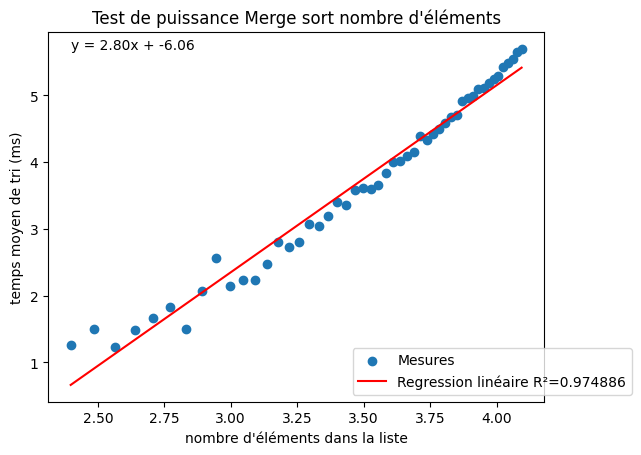

In [ ]:
def dict_from_measures(measures: list[Measure]) -> dict:
    dict = {}
    for measure in measures:
        dict[np.log(measure.size)] = np.log(measure.mean)
    return dict

dict_greedy_sol = dict_from_measures(resultats_greedy)

test_de_puissance(dict_greedy_sol, "log de la grandeur de n", 'temps log moyen pour trouver la solution (ms)', "Test de puissance pour algorithme glouton")

Comme on peut voir sur le test de puissance, notre échelle log-log pour nos données nous donne une complexité autour de theta n^2.8, ce qui était attendu, mais beaucoup mieux que notre hypothèse de départ. Nous pensions que c'était theta(n^4), mais en pratique notre algorithme greedy performe beaucoup mieux que nous le pensions. 

### Test de rapport

Ici, on fait un test de rapport pour vérifier tout de même si notre hypothèse de départ peut être sensée, même si on sait maintenant que notre vraie complexité pratique est plutôt theta(n^2.8). C'est le dernier test que l'on considère pour cette partie, car on a pas besoin de faire le test de constance étant donné que nous n'avons qu'une variable dans notre algorithme

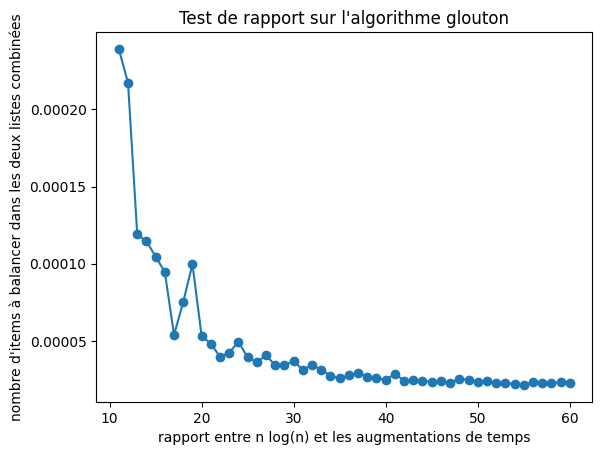

In [ ]:
import math
def change_to_predict(measures: list[Measure], hypothesis = lambda x: x) -> dict:
    new_dict = {}
    for key in measures:
        new_dict[key.size] = key.mean/hypothesis(key.size)
    return new_dict

test_de_rapport(change_to_predict(resultats_greedy, lambda x: x**4), "grandeur de n", "temps moyen pour trouver la solution divisé par n^4 (ms)" , "Test de rapport sur l'algorithme glouton")

Comme on peut le voir, on converge mais on se rapproche extrèmement de 0, ce qui indique qu'on surestime la valeur de notre complexité. C'est tout à fait normal vu qu'on vient de voir une valeur de theta(n^2.8) en pratique. Par contre, il est tout de même possible avec la différence de vitesse sur nos machines que la vraie complexité varie dépendamment de facteurs qu'on ne peut pas controller.

### Greedy et Amélioration locale avec un seul passage

Ici, on réécris notre algorithme avec amélioration locale, pour évaluer la complexité de notre solution finale. Si on se souviens bien, notre hypothèse était une complexité d'au plus theta n^4 

In [14]:

def main_amelioration(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    updated = amelioration_locale(groups, target, n, sample, sol)
    sol = updated
    return sol

#### Génération de moyennes

Ici on génère les moyennes de la même façon

In [15]:
resultats_am_locale = measure_range(main_amelioration, problems)

display_data_as_table(resultats_am_locale)

initial solution


100%|██████████| 11/11 [00:00<00:00, 7301.37it/s]


--- 0.003362894058227539 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 9288.77it/s]


--- 0.0031235218048095703 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 3024.01it/s]


--- 0.003637552261352539 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 7815.91it/s]


--- 0.0032913684844970703 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.003419160842895508 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 8801.48it/s]


--- 0.004509687423706055 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5125.80it/s]


--- 0.003159761428833008 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 8881.11it/s]


--- 0.003390789031982422 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 7027.78it/s]


--- 0.0038614273071289062 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.004225492477416992 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 10866.07it/s]


--- 0.004874706268310547 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4067.86it/s]


--- 0.002949953079223633 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4721.99it/s]


--- 0.0025413036346435547 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 7970.17it/s]


--- 0.0037436485290527344 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 3459.46it/s]


--- 0.003468751907348633 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11839.95it/s]


--- 0.005226612091064453 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.007013559341430664 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.001436471939086914 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11842.74it/s]


--- 0.005692481994628906 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 2191.95it/s]


--- 0.007854223251342773 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 1854.25it/s]


--- 0.016276836395263672 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 1621.98it/s]


--- 0.008014917373657227 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 3031.07it/s]


--- 0.004288911819458008 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6129.27it/s]


--- 0.0031261444091796875 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 8701.88it/s]


--- 0.004084110260009766 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 9840.45it/s]


--- 0.004052162170410156 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 12869.00it/s]


--- 0.008182048797607422 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0029501914978027344 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5790.38it/s]


--- 0.008385181427001953 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.002269744873046875 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6196.08it/s]


--- 0.003266572952270508 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 3882.84it/s]


--- 0.0036056041717529297 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.008076190948486328 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4022.49it/s]


--- 0.0034804344177246094 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.004678964614868164 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.0035228729248046875 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5094.59it/s]


--- 0.006593465805053711 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6970.59it/s]


--- 0.0045545101165771484 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]

--- 0.003231525421142578 seconds for solution baseline ---
initial solution



100%|██████████| 15/15 [00:00<00:00, 4328.78it/s]


--- 0.0057942867279052734 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3606.25it/s]


--- 0.005275726318359375 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 8011.53it/s]


--- 0.006085872650146484 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3577.13it/s]


--- 0.004193305969238281 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 11420.32it/s]


--- 0.004647493362426758 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 5820.57it/s]


--- 0.009149312973022461 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 5958.38it/s]


--- 0.005825996398925781 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 11899.86it/s]


--- 0.0025577545166015625 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 8616.07it/s]


--- 0.0039594173431396484 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5847.25it/s]


--- 0.0064890384674072266 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 6328.04it/s]


--- 0.007370471954345703 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 15786.61it/s]


--- 0.0035500526428222656 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3099.86it/s]


--- 0.0051615238189697266 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.00618743896484375 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5666.06it/s]


--- 0.005398988723754883 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.002307891845703125 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5159.84it/s]


--- 0.0054399967193603516 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4941.38it/s]


--- 0.005344867706298828 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 6348.99it/s]


--- 0.0069806575775146484 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4366.66it/s]


--- 0.005412101745605469 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0010137557983398438 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 13194.52it/s]


--- 0.0035848617553710938 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4299.52it/s]


--- 0.006498098373413086 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 7402.74it/s]


--- 0.005553007125854492 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3086.58it/s]


--- 0.00684666633605957 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2639.88it/s]


--- 0.006439685821533203 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 5438.01it/s]


--- 0.006963968276977539 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4112.77it/s]


--- 0.005147695541381836 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3998.38it/s]


--- 0.008437871932983398 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2830.06it/s]


--- 0.007708549499511719 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3601.46it/s]


--- 0.007617473602294922 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 6559.86it/s]


--- 0.007581472396850586 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<?, ?it/s]


--- 0.005099773406982422 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 16008.79it/s]


--- 0.007312774658203125 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4646.28it/s]


--- 0.007573127746582031 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2122.09it/s]


--- 0.008482217788696289 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 17651.97it/s]


--- 0.006752490997314453 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<?, ?it/s]

--- 0.002011537551879883 seconds for solution baseline ---
initial solution



100%|██████████| 18/18 [00:00<00:00, 5552.92it/s]


--- 0.005621671676635742 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4605.13it/s]


--- 0.010432243347167969 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3021.03it/s]


--- 0.009494304656982422 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4029.31it/s]


--- 0.009700536727905273 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4600.34it/s]


--- 0.007489919662475586 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3612.17it/s]


--- 0.009306192398071289 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3942.21it/s]


--- 0.008359432220458984 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3437.66it/s]


--- 0.009424448013305664 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<?, ?it/s]


--- 0.011483192443847656 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1856.75it/s]


--- 0.011399984359741211 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4038.50it/s]


--- 0.008155345916748047 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 5581.61it/s]


--- 0.008427619934082031 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1330.85it/s]

--- 0.026250362396240234 seconds for solution baseline ---


initial solution


100%|██████████| 20/20 [00:00<00:00, 3628.45it/s]


--- 0.00821065902709961 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3953.72it/s]

--- 0.009270191192626953 seconds for solution baseline ---
initial solution



100%|██████████| 20/20 [00:00<00:00, 16565.18it/s]


--- 0.0063021183013916016 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 4722.25it/s]


--- 0.013511896133422852 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3779.67it/s]


--- 0.008373022079467773 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3254.80it/s]


--- 0.008357524871826172 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1891.75it/s]


--- 0.011578083038330078 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<?, ?it/s]


--- 0.0036563873291015625 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 5787.53it/s]


--- 0.007643938064575195 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2794.52it/s]


--- 0.011278152465820312 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<?, ?it/s]


--- 0.012232780456542969 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 4736.01it/s]


--- 0.009798526763916016 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2940.13it/s]


--- 0.010109424591064453 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<?, ?it/s]

--- 0.013046026229858398 seconds for solution baseline ---
initial solution



100%|██████████| 21/21 [00:00<00:00, 2655.74it/s]


--- 0.007907390594482422 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2671.37it/s]


--- 0.01295614242553711 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 6180.21it/s]


--- 0.006476879119873047 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 1540.41it/s]


--- 0.013632774353027344 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2569.47it/s]


--- 0.01287221908569336 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2463.35it/s]


--- 0.015430927276611328 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2886.83it/s]


--- 0.007620811462402344 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3014.92it/s]


--- 0.009979486465454102 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2837.56it/s]


--- 0.013426780700683594 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3106.26it/s]


--- 0.014254331588745117 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2709.74it/s]


--- 0.012901067733764648 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2202.47it/s]


--- 0.009988784790039062 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2877.47it/s]


--- 0.013053417205810547 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3578.34it/s]


--- 0.012367725372314453 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2260.07it/s]


--- 0.01351475715637207 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 3519.48it/s]


--- 0.009234189987182617 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 3969.59it/s]


--- 0.00873112678527832 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2764.31it/s]


--- 0.012029886245727539 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2654.99it/s]


--- 0.012383460998535156 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 3410.85it/s]


--- 0.01363682746887207 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2808.25it/s]


--- 0.012703180313110352 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2535.32it/s]


--- 0.010101556777954102 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 5923.79it/s]


--- 0.008811235427856445 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2087.08it/s]


--- 0.015503406524658203 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2802.20it/s]


--- 0.01307988166809082 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2388.10it/s]


--- 0.011756181716918945 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2216.33it/s]


--- 0.01467275619506836 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1953.56it/s]


--- 0.017158031463623047 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1947.48it/s]


--- 0.012323617935180664 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2483.37it/s]


--- 0.01820850372314453 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2664.39it/s]


--- 0.01173853874206543 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2005.44it/s]


--- 0.017849445343017578 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2055.36it/s]


--- 0.015491485595703125 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1544.01it/s]


--- 0.016114234924316406 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2714.90it/s]


--- 0.01344156265258789 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 4126.79it/s]


--- 0.00832819938659668 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2562.19it/s]


--- 0.0133819580078125 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1686.49it/s]


--- 0.014823675155639648 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 3886.35it/s]


--- 0.0104827880859375 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2332.14it/s]


--- 0.012451648712158203 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2222.93it/s]


--- 0.013751029968261719 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 4526.16it/s]


--- 0.008029937744140625 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1621.55it/s]


--- 0.015417337417602539 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 3150.67it/s]


--- 0.015245199203491211 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2318.08it/s]


--- 0.07921719551086426 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1814.87it/s]


--- 0.016402482986450195 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1755.08it/s]


--- 0.024443626403808594 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2415.38it/s]


--- 0.01363682746887207 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2118.34it/s]


--- 0.019231319427490234 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1610.48it/s]


--- 0.021057844161987305 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 2143.61it/s]


--- 0.017687082290649414 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1219.70it/s]


--- 0.02500462532043457 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1647.16it/s]


--- 0.01853322982788086 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1715.35it/s]


--- 0.017770051956176758 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1828.91it/s]


--- 0.01656651496887207 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 3226.20it/s]


--- 0.014122486114501953 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 4860.56it/s]

--- 0.024303913116455078 seconds for solution baseline ---
initial solution



100%|██████████| 27/27 [00:00<00:00, 3005.31it/s]


--- 0.01865553855895996 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1904.03it/s]


--- 0.022583484649658203 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1782.53it/s]


--- 0.01901721954345703 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2973.75it/s]


--- 0.01252889633178711 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2747.23it/s]


--- 0.01702117919921875 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2243.03it/s]

--- 0.018682241439819336 seconds for solution baseline ---


initial solution


100%|██████████| 27/27 [00:00<00:00, 2158.92it/s]


--- 0.018033981323242188 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 3295.10it/s]


--- 0.02518010139465332 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 2307.60it/s]


--- 0.016283035278320312 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 2096.40it/s]


--- 0.02104973793029785 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1684.39it/s]


--- 0.026858806610107422 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 2393.96it/s]


--- 0.015880584716796875 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1488.66it/s]


--- 0.023971080780029297 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1724.66it/s]


--- 0.022114992141723633 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 2300.50it/s]


--- 0.016593456268310547 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1786.44it/s]


--- 0.02496027946472168 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1756.86it/s]


--- 0.019153594970703125 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1182.85it/s]


--- 0.02505326271057129 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1217.10it/s]


--- 0.023827075958251953 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1568.81it/s]


--- 0.03181958198547363 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 907.32it/s]

--- 0.04113340377807617 seconds for solution baseline ---
initial solution



100%|██████████| 29/29 [00:00<00:00, 1751.96it/s]


--- 0.023653030395507812 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1760.40it/s]


--- 0.021013259887695312 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1735.58it/s]


--- 0.020992517471313477 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1781.78it/s]


--- 0.023946762084960938 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1626.07it/s]


--- 0.0209805965423584 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1662.65it/s]

--- 0.025111675262451172 seconds for solution baseline ---


initial solution


100%|██████████| 30/30 [00:00<00:00, 1717.83it/s]


--- 0.021671533584594727 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1661.35it/s]


--- 0.024991989135742188 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1899.16it/s]


--- 0.018998146057128906 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1844.41it/s]


--- 0.02447199821472168 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1288.65it/s]


--- 0.027548551559448242 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1142.55it/s]


--- 0.026257038116455078 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1580.17it/s]


--- 0.02271580696105957 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1615.56it/s]


--- 0.023082256317138672 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1476.49it/s]


--- 0.031682729721069336 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1763.65it/s]


--- 0.028949260711669922 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1218.00it/s]


--- 0.03506612777709961 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 870.21it/s]


--- 0.04061388969421387 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 930.14it/s]


--- 0.03934741020202637 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1530.88it/s]


--- 0.02575993537902832 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1384.44it/s]


--- 0.03479886054992676 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1106.01it/s]


--- 0.031867265701293945 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 996.91it/s]


--- 0.038184404373168945 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 901.69it/s]


--- 0.043657541275024414 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1300.92it/s]


--- 0.025341510772705078 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1355.63it/s]


--- 0.02388453483581543 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1377.88it/s]

--- 0.030261754989624023 seconds for solution baseline ---


initial solution


100%|██████████| 32/32 [00:00<00:00, 1377.54it/s]


--- 0.033661603927612305 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1666.47it/s]


--- 0.03141379356384277 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1332.90it/s]


--- 0.030951738357543945 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1423.11it/s]


--- 0.025353431701660156 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1491.66it/s]


--- 0.02504563331604004 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1417.13it/s]


--- 0.032495975494384766 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1650.27it/s]


--- 0.02295994758605957 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1528.40it/s]


--- 0.02554488182067871 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1506.39it/s]


--- 0.024884462356567383 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1144.84it/s]


--- 0.04050278663635254 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1176.51it/s]


--- 0.03245711326599121 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1291.84it/s]


--- 0.0317840576171875 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1610.32it/s]


--- 0.030690670013427734 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1310.29it/s]


--- 0.030457258224487305 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1114.64it/s]


--- 0.038016319274902344 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 738.24it/s]


--- 0.048188209533691406 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1060.11it/s]


--- 0.032643795013427734 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 995.30it/s]


--- 0.040180206298828125 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1046.11it/s]


--- 0.031545400619506836 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1197.21it/s]


--- 0.03397178649902344 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1112.12it/s]


--- 0.04203033447265625 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1075.60it/s]


--- 0.03807353973388672 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1035.43it/s]


--- 0.040120601654052734 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1000.09it/s]


--- 0.03952741622924805 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 985.80it/s]


--- 0.03448963165283203 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 1109.35it/s]


--- 0.03484511375427246 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 995.56it/s]

--- 0.03619050979614258 seconds for solution baseline ---
initial solution



100%|██████████| 34/34 [00:00<00:00, 1079.17it/s]


--- 0.039801597595214844 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 691.96it/s]


--- 0.11420559883117676 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 886.19it/s]


--- 0.04356741905212402 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1057.63it/s]


--- 0.04235363006591797 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 967.02it/s]


--- 0.03922319412231445 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 895.52it/s]


--- 0.04051494598388672 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1031.46it/s]


--- 0.03683018684387207 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 866.32it/s]


--- 0.04867982864379883 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1086.99it/s]


--- 0.04812908172607422 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 749.96it/s]


--- 0.04779195785522461 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 828.68it/s]


--- 0.052602291107177734 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1096.03it/s]


--- 0.0335230827331543 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 858.25it/s]


--- 0.0479738712310791 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 870.81it/s]


--- 0.051796674728393555 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 872.63it/s]


--- 0.04284548759460449 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 903.71it/s]

--- 0.05129814147949219 seconds for solution baseline ---


initial solution


100%|██████████| 36/36 [00:00<00:00, 939.46it/s]


--- 0.04107546806335449 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 1052.78it/s]


--- 0.04137372970581055 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 1122.51it/s]


--- 0.04134106636047363 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 929.05it/s]


--- 0.043961286544799805 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 927.97it/s]


--- 0.03998684883117676 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 799.03it/s]


--- 0.05599665641784668 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 902.33it/s]


--- 0.049083709716796875 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 951.81it/s]


--- 0.03887343406677246 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 1160.08it/s]


--- 0.04949522018432617 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 909.22it/s]


--- 0.04952216148376465 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 864.85it/s]


--- 0.04677915573120117 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 555.27it/s]


--- 0.07459044456481934 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 799.55it/s]


--- 0.05052065849304199 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 485.14it/s]


--- 0.0773320198059082 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 852.68it/s]

--- 0.051635026931762695 seconds for solution baseline ---


initial solution


100%|██████████| 37/37 [00:00<00:00, 856.04it/s]


--- 0.04671216011047363 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 931.74it/s]


--- 0.04855942726135254 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 796.76it/s]


--- 0.059181928634643555 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 859.21it/s]


--- 0.049612998962402344 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 876.85it/s]


--- 0.04883241653442383 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 874.39it/s]


--- 0.05024099349975586 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 732.79it/s]


--- 0.062306880950927734 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 876.63it/s]


--- 0.05366325378417969 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 705.39it/s]


--- 0.05489087104797363 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 771.60it/s]


--- 0.05471038818359375 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 876.31it/s]


--- 0.048207998275756836 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 667.35it/s]


--- 0.06296777725219727 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 799.73it/s]


--- 0.05137300491333008 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 598.32it/s]


--- 0.07404422760009766 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 374.36it/s]


--- 0.17182064056396484 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 708.73it/s]


--- 0.06526613235473633 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 744.30it/s]


--- 0.05847311019897461 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 762.58it/s]


--- 0.05567669868469238 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 768.72it/s]


--- 0.05873370170593262 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 750.84it/s]


--- 0.05824899673461914 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 690.35it/s]


--- 0.06537604331970215 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 622.70it/s]

--- 0.07177424430847168 seconds for solution baseline ---
initial solution



100%|██████████| 40/40 [00:00<00:00, 660.17it/s]


--- 0.06059002876281738 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 829.52it/s]


--- 0.05544543266296387 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 695.54it/s]


--- 0.06402826309204102 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 384.24it/s]


--- 0.11412501335144043 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 615.08it/s]


--- 0.07588481903076172 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 619.22it/s]


--- 0.0672605037689209 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 648.70it/s]


--- 0.06688284873962402 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 671.28it/s]


--- 0.06529998779296875 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 669.33it/s]


--- 0.06656956672668457 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 601.50it/s]


--- 0.07301759719848633 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 607.28it/s]


--- 0.07340812683105469 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 687.34it/s]


--- 0.06384515762329102 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 346.56it/s]


--- 0.12029385566711426 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 676.59it/s]


--- 0.06728672981262207 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 706.90it/s]


--- 0.06418919563293457 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 708.52it/s]


--- 0.0633077621459961 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 629.02it/s]


--- 0.06712818145751953 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 514.23it/s]


--- 0.08812308311462402 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 627.57it/s]


--- 0.07782173156738281 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 636.44it/s]


--- 0.07454657554626465 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 572.15it/s]


--- 0.15610003471374512 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 633.08it/s]


--- 0.06904721260070801 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 565.82it/s]


--- 0.08241415023803711 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 622.37it/s]


--- 0.07129955291748047 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 698.61it/s]


--- 0.06512594223022461 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 621.99it/s]


--- 0.07393908500671387 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 498.29it/s]


--- 0.09840726852416992 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 684.18it/s]


--- 0.06764578819274902 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 634.50it/s]


--- 0.06619429588317871 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 511.35it/s]


--- 0.08875632286071777 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 523.04it/s]


--- 0.09606409072875977 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 586.43it/s]


--- 0.08123064041137695 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 630.84it/s]


--- 0.0696711540222168 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 411.80it/s]


--- 0.10926008224487305 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 648.47it/s]


--- 0.07441306114196777 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 559.20it/s]


--- 0.08071351051330566 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 594.40it/s]


--- 0.08366250991821289 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 571.00it/s]


--- 0.08169269561767578 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 444.41it/s]


--- 0.10945725440979004 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 509.93it/s]


--- 0.09743261337280273 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 535.57it/s]


--- 0.08435559272766113 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 517.54it/s]


--- 0.09790253639221191 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 302.52it/s]


--- 0.15423798561096191 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 529.66it/s]


--- 0.10001516342163086 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 539.14it/s]


--- 0.0902097225189209 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 519.23it/s]


--- 0.09000062942504883 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 584.40it/s]


--- 0.1431119441986084 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 487.32it/s]


--- 0.09599947929382324 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 537.65it/s]


--- 0.08183717727661133 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 425.59it/s]


--- 0.11420106887817383 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 475.65it/s]


--- 0.1018228530883789 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 442.40it/s]


--- 0.10972452163696289 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 344.81it/s]


--- 0.13524341583251953 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 458.48it/s]


--- 0.10638713836669922 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 553.80it/s]


--- 0.08978390693664551 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 490.31it/s]


--- 0.10086655616760254 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 467.27it/s]


--- 0.0992422103881836 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 509.02it/s]


--- 0.09804534912109375 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 542.39it/s]


--- 0.09671258926391602 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 349.81it/s]


--- 0.13203787803649902 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 449.90it/s]


--- 0.10989093780517578 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 498.23it/s]


--- 0.09858846664428711 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 480.58it/s]


--- 0.10463118553161621 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 488.59it/s]


--- 0.09996771812438965 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 399.24it/s]


--- 0.12460494041442871 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 525.90it/s]


--- 0.10015082359313965 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 479.49it/s]


--- 0.10527157783508301 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 305.92it/s]

--- 0.1562654972076416 seconds for solution baseline ---


initial solution


100%|██████████| 46/46 [00:00<00:00, 504.05it/s]


--- 0.17017745971679688 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 410.48it/s]


--- 0.11636209487915039 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 423.21it/s]


--- 0.11586952209472656 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 444.25it/s]


--- 0.1194462776184082 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 452.93it/s]


--- 0.1098332405090332 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 432.65it/s]


--- 0.11664056777954102 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 448.08it/s]


--- 0.11295056343078613 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 423.61it/s]


--- 0.1218268871307373 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 444.96it/s]


--- 0.1143639087677002 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 419.58it/s]


--- 0.1185922622680664 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 477.92it/s]


--- 0.1060945987701416 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 340.73it/s]


--- 0.1434648036956787 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 477.02it/s]


--- 0.11064505577087402 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 444.99it/s]


--- 0.11590719223022461 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 374.28it/s]


--- 0.13536739349365234 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 419.68it/s]


--- 0.11947941780090332 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 346.74it/s]


--- 0.14442682266235352 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 456.28it/s]


--- 0.12151002883911133 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 437.33it/s]


--- 0.11777448654174805 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 430.68it/s]


--- 0.11459159851074219 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 428.77it/s]


--- 0.196458101272583 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 390.79it/s]


--- 0.13222002983093262 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 376.59it/s]


--- 0.13163256645202637 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 400.08it/s]


--- 0.13344860076904297 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 413.63it/s]


--- 0.1254260540008545 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 400.41it/s]


--- 0.1320939064025879 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 380.65it/s]


--- 0.13716673851013184 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 309.25it/s]

--- 0.16564106941223145 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 394.39it/s]


--- 0.13394951820373535 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 360.03it/s]


--- 0.14511561393737793 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 373.28it/s]


--- 0.13744640350341797 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 355.39it/s]


--- 0.1486968994140625 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 338.12it/s]


--- 0.15821409225463867 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 363.29it/s]

--- 0.14498257637023926 seconds for solution baseline ---
initial solution



100%|██████████| 50/50 [00:00<00:00, 392.22it/s]


--- 0.1312720775604248 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 375.44it/s]


--- 0.1380612850189209 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 397.31it/s]


--- 0.13489794731140137 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 429.67it/s]


--- 0.12311959266662598 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 380.25it/s]


--- 0.20585036277770996 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 383.42it/s]


--- 0.14268994331359863 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 379.03it/s]


--- 0.1391162872314453 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 299.64it/s]


--- 0.17939329147338867 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 392.56it/s]


--- 0.13642239570617676 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 350.24it/s]


--- 0.15819478034973145 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 343.97it/s]


--- 0.15736842155456543 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 354.17it/s]

--- 0.15621376037597656 seconds for solution baseline ---
initial solution



100%|██████████| 51/51 [00:00<00:00, 392.60it/s]

--- 0.14484906196594238 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 368.88it/s]

--- 0.14633965492248535 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 360.86it/s]

--- 0.14858126640319824 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 360.87it/s]

--- 0.15211796760559082 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 325.34it/s]


--- 0.1633312702178955 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 284.58it/s]


--- 0.19579672813415527 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 353.94it/s]


--- 0.15565752983093262 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 342.46it/s]


--- 0.15861868858337402 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 346.84it/s]


--- 0.22285723686218262 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 346.26it/s]


--- 0.15683722496032715 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 333.45it/s]


--- 0.16453123092651367 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 318.64it/s]


--- 0.168259859085083 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 335.58it/s]


--- 0.1636343002319336 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 354.45it/s]


--- 0.1548750400543213 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 347.98it/s]


--- 0.15682172775268555 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 294.23it/s]


--- 0.18942737579345703 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 300.13it/s]


--- 0.1817936897277832 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 317.07it/s]


--- 0.17702221870422363 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 337.33it/s]


--- 0.16668128967285156 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 264.17it/s]


--- 0.20810890197753906 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 319.34it/s]


--- 0.1659684181213379 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 326.56it/s]

--- 0.17141366004943848 seconds for solution baseline ---
initial solution



100%|██████████| 53/53 [00:00<00:00, 310.12it/s]


--- 0.18119215965270996 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 228.56it/s]


--- 0.2344212532043457 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 336.08it/s]


--- 0.17199039459228516 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 287.12it/s]


--- 0.20111393928527832 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 299.80it/s]


--- 0.1880021095275879 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 299.79it/s]


--- 0.1820673942565918 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 311.61it/s]


--- 0.17874765396118164 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 309.80it/s]


--- 0.18192338943481445 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 301.43it/s]


--- 0.18965458869934082 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 290.98it/s]


--- 0.19716501235961914 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 300.31it/s]


--- 0.18935656547546387 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 303.56it/s]


--- 0.18408632278442383 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 268.06it/s]


--- 0.22075366973876953 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 299.12it/s]


--- 0.1902625560760498 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 308.48it/s]


--- 0.17829108238220215 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 256.67it/s]


--- 0.2235112190246582 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 280.68it/s]


--- 0.2962310314178467 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 302.20it/s]


--- 0.18886876106262207 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 272.96it/s]


--- 0.21277427673339844 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 259.26it/s]


--- 0.22224092483520508 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 298.68it/s]


--- 0.19083857536315918 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 281.41it/s]


--- 0.20607614517211914 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 282.21it/s]


--- 0.203779935836792 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 309.27it/s]


--- 0.19625639915466309 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 279.92it/s]


--- 0.2070751190185547 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 269.51it/s]


--- 0.21230673789978027 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 266.64it/s]


--- 0.21775174140930176 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 272.44it/s]


--- 0.213148832321167 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 206.41it/s]


--- 0.2793159484863281 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 243.51it/s]


--- 0.31516075134277344 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 251.92it/s]


--- 0.2385108470916748 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 288.33it/s]


--- 0.2033219337463379 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 276.06it/s]


--- 0.2124476432800293 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 264.37it/s]


--- 0.22891592979431152 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 233.85it/s]


--- 0.25031208992004395 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 238.76it/s]


--- 0.24640130996704102 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 252.23it/s]


--- 0.23180460929870605 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 263.52it/s]


--- 0.2203991413116455 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 258.02it/s]


--- 0.22734737396240234 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 259.36it/s]


--- 0.22522211074829102 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 266.31it/s]


--- 0.22483420372009277 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 261.73it/s]


--- 0.3003120422363281 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 234.75it/s]


--- 0.2509610652923584 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 222.80it/s]


--- 0.27022337913513184 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 243.43it/s]


--- 0.24610447883605957 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 220.15it/s]


--- 0.2756211757659912 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 229.54it/s]


--- 0.2619631290435791 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 232.01it/s]


--- 0.26158690452575684 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 260.98it/s]


--- 0.22833728790283203 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 245.16it/s]


--- 0.2472667694091797 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 239.22it/s]


--- 0.24959468841552734 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 207.90it/s]


--- 0.2889580726623535 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 228.05it/s]


--- 0.26511621475219727 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 241.07it/s]


--- 0.3354036808013916 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 245.25it/s]


--- 0.24890470504760742 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 228.27it/s]


--- 0.26511073112487793 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 198.90it/s]


--- 0.3062455654144287 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 254.69it/s]


--- 0.23998332023620605 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 225.50it/s]


--- 0.27723073959350586 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 241.83it/s]


--- 0.2535533905029297 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 209.20it/s]


--- 0.28987860679626465 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 211.83it/s]


--- 0.2856743335723877 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 247.18it/s]


--- 0.25357484817504883 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 228.06it/s]


--- 0.2688918113708496 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 228.19it/s]


--- 0.3540611267089844 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 219.57it/s]


--- 0.28362584114074707 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 214.80it/s]


--- 0.2853400707244873 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 218.62it/s]


--- 0.2877237796783447 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 217.10it/s]


--- 0.2790515422821045 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 225.36it/s]


--- 0.28234195709228516 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 197.49it/s]


--- 0.31272339820861816 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 233.51it/s]


--- 0.2656846046447754 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 224.35it/s]


--- 0.27725720405578613 seconds for solution baseline ---
Taille       Temps moyen  Score moyen 
11           3.7          272.54545454545456
12           4.5          449.2333333333334
13           5.6          558.2384615384615
14           4.9          797.6928571428572
15           5.8          813.9733333333334
16           5.3          1172.525    
17           5.8          1373.7470588235294
18           7.2          1565.35     
19           10.3         2068.415789473684
20           11.2         2223.32     
21           12.2         2402.3952380952383
22           12.8         2849.5272727272727
23           13.4         3307.317391304348
24           15.7         3803.775    
25           14.4         3239.472    
26           26.1         4221.3115384615385
27           19.6         4389.451851851852
28           23.1         5024.746428571429
29           27.4         4999.520689655173
30           27.7         5962.333333333334
31           36.7         6065.974193548387

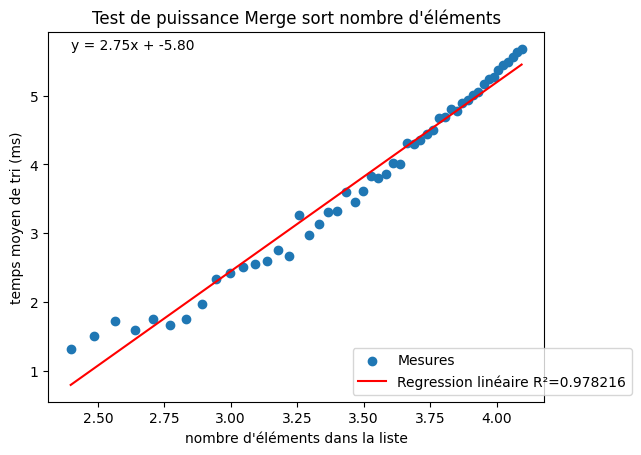

In [16]:
dict_am_locale = dict_from_measures(resultats_am_locale)

test_de_puissance(dict_am_locale, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")

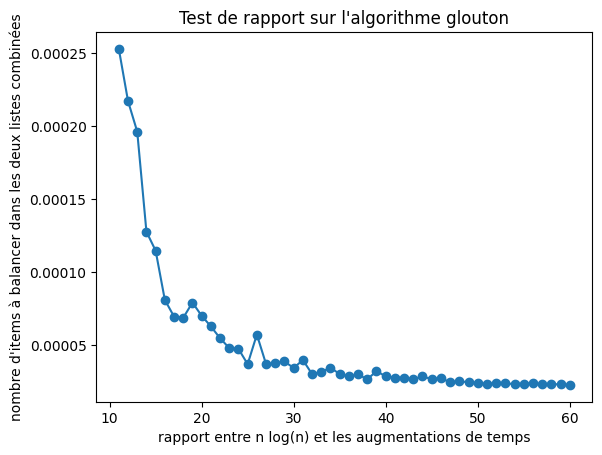

In [17]:
test_de_rapport(change_to_predict(resultats_am_locale, lambda x: x**4), "rapport entre n log(n) et les augmentations de temps", "nombre d'items à balancer dans les deux listes combinées" , "Test de rapport sur l'algorithme glouton")

### Amélioration locale

Ceci était un essaie qui ne fonctionne pas de calculer indépendamment l'amélioration locale

In [ ]:
# def main_preparation(sample):
#     start_time = time.time()
#     n = len(sample)
#     target = 500 * n
#     counties = set_counties(sample)
#     sol, groups = max_to_target(counties, target, n)
#     return (sol, groups, sample, n, target, counties)
    

In [ ]:
# problems = make_problems([x for x in range(11, 15)], 10)
# resultats_initials = {"solutions_initiales": [],
#                        "groupes": [],
#                        "samples": [],
#                        "ns": [],
#                        "targets": [], 
#                        "counties": []}
# for prob in problems:
#     solutions_initiales, groupes, samples, ns, targets, counties = [], [], [], [], [], []
#     sols = [main_preparation(sample) for sample in prob.generate_dataset()]
#     for sol in sols:
#         solutions_initiales.append(sol[0])
#         groupes.append(sol[1])
#         samples.append(sol[2])
#         ns.append(sol[3])
#         targets.append(sol[4])
#         counties.append(sol[5])
    
#     resultats_initials["solutions_initiales"].append(solutions_initiales)
#     resultats_initials["groupes"].append(groupes)
#     resultats_initials["samples"].append(samples)
#     resultats_initials["ns"].append(ns)
#     resultats_initials["targets"].append(targets)
#     resultats_initials["counties"].append(counties)



100%|██████████| 14/14 [00:00<00:00, 13852.38it/s]


In [ ]:

# def main_amelioration(sample, resultats_initials):
#     start_time = time.time()
#     max_time = 60 * 3 - 1
#     n = len(sample)
#     target = resultats_initials
#     counties = resultats_initials["counties"]
#     print('initial solution')
#     sol, groups = max_to_target(counties, target, n)
#     if (time.time() - start_time) > max_time:
#         return sol
#     print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

#     first_iter = True
#     iter_time = time.time()
#     time_to_iter = 0
#     print('improvement')
#     while(True):
#         updated = amelioration_locale(groups, target, n, sample, sol)
#         sol = updated

In [ ]:
# print(resultats_initials["groupes"])

# resultats_am_locale = measure(lambda x: amelioration_locale(x["groupes"][0][0], x["targets"][0][0], x["ns"][0][0], x["samples"][0][0], x["solutions_initiales"][0][0]), resultats_initials)

# display_data_as_table(resultats_graphs)

[[[[<__main__.County object at 0x00000281101177A0>, <__main__.County object at 0x0000028110117140>, <__main__.County object at 0x0000028110116750>, <__main__.County object at 0x0000028110156D50>, <__main__.County object at 0x0000028110157F50>, <__main__.County object at 0x0000028110146660>, <__main__.County object at 0x0000028110147AD0>, <__main__.County object at 0x0000028110114140>, <__main__.County object at 0x0000028110116F00>, <__main__.County object at 0x0000028110116210>, <__main__.County object at 0x0000028110117110>], [<__main__.County object at 0x000002811010D340>, <__main__.County object at 0x000002811010CE60>, <__main__.County object at 0x00000281101A8C20>, <__main__.County object at 0x0000028110145550>, <__main__.County object at 0x0000028110147530>, <__main__.County object at 0x0000028110145EB0>, <__main__.County object at 0x0000028110147B90>, <__main__.County object at 0x0000028110116810>, <__main__.County object at 0x00000281101150D0>, <__main__.County object at 0x00000

InvalidSolution: Invalid solution, verify your code.

In [ ]:
# def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
#     """Returns a tuple containing the time as well as the score of the solution, in that order.
    
#     Parameters:
#         time_scale: Controls the level of precision of the time measurements.

#     Raises:
#         InvalidSolution: If the procedure returns an invalid solution, raises an exception.
#     """
#     start: int = time.time() * time_scale
#     solution: list[int] = procedure(sample)
#     end: int = time.time() * time_scale
#     if not is_valid_solution(sample, solution):
#         raise InvalidSolution()
#     return (round(end - start), score_solution(sample, solution))

# def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, greedy_results, time_scale: int = 1000) -> Measure:
#     """Generates multiple samples with the specified parameters and returns a Measure 
#     instance representing the result as well as the problem.

#     Raises:
#         InvalidSolution: If one of the samples results in an invalid solution.
#     """
#     results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
#     mean_time = sum(result[0] for result in results) / prob.num_samples
#     mean_score = sum(result[1] for result in results) / prob.num_samples
#     return Measure(prob.size, mean_time, mean_score)

# def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
#     """Measures the mean time taken for each problem in the given list.

#     Raises:
#         InvalidSolution: If one of the samples results in an invalid solution.

#     Returns:
#         A list of Measure instances containing the specifications
#         of the problem as well as the mean time and the score.
#     """
#     return [
#         measure_mean(procedure, problems[i], resultats_initials[], time_scale)
#         for i in len(problems)
#     ]

Nous avons essayé de faire l'analyse de la fonction d'amélioration locale indépendemment de l'algorithme principal. Par contre, comme l'amélioration locale demande une solution initiale sur laquelle faire l'amélioration et les fonctions fournies ne nous permettent pas isoler cette section de l'analyse. Par contre, nous avons fais l'analyse de la section de génération initale et aussi l'analyse de la génération initiale avec un passage d'amélioration locale. Nous voyons entre les deux analyse qu'il n'y a aucune différence d'ordre de grandeur. Ceci peux seulement nous borner supérieurement la complexité de notre amélioration locale qui est au pire dans le même ordre que la génération initiale. Nous savons que c'est O(n⁴) héoriquement et en pratique plus près de O(n³). Bref, un passage d'amélioration locale n'affecte pas l'ordre de grandeur, car il est au maximum aussi grand que nous génération de solution initiale.

# Analyse code carbon (2 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.

In [ ]:
from codecarbon import EmissionsTracker, OfflineEmissionsTracker
try:
    tracker_USA = OfflineEmissionsTracker(measure_power_secs=5, tracking_mode="process", country_iso_code='USA')
    # tracker_CAD = OfflineEmissionsTracker(measure_power_secs=5, country_iso_code='CAN')
    # tracker_JPN = OfflineEmissionsTracker(measure_power_secs=5, country_iso_code='JPN')
    # tracker_FRA = OfflineEmissionsTracker(measure_power_secs=5, country_iso_code='FRA')
    # tracker_CHN = OfflineEmissionsTracker(measure_power_secs=5, country_iso_code='CHN')

    tracker_USA.start_task("main_USA")
    # tracker_CAD.start_task("main_CAD")
    # tracker_JPN.start_task("main_JPN")
    # tracker_FRA.start_task("main_FRA")
    # tracker_CHN.start_task("main_CHN")

    results = measure_range(main, make_problems([100], 1) )
    tracker_USA.stop_task()
    # tracker_CAD.stop_task()
    # tracker_JPN.stop_task()
    # tracker_FRA.stop_task()
    # tracker_CHN.stop_task()

finally:
    _ = tracker_USA.stop()
    # _ = tracker_CAD.stop()
    # _ = tracker_JPN.stop()
    # _ = tracker_FRA.stop()
    # _ = tracker_CHN.stop()

[codecarbon INFO @ 23:16:40] offline tracker init
[codecarbon ERROR @ 23:16:40] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 23:16:40] Another instance of codecarbon is already running. Exiting.


AttributeError: 'OfflineEmissionsTracker' object has no attribute '_scheduler'

# Conclusion (6 pts)

# Étapes d'amélioration pour arriver à notre version actuelle
Nous avons commencé par un algorithme glouton qui n'avait aucune gestion du temps et aucune amélioration après le passage initial. Cet algorithme était en theta(n³) au lieu de theta(n⁴) comme notre algorithme actuel, car nous faisions une selection  du premier élément d'un groupe de manière complètment aléatoire. De plus, lorsqu'il n'y avait pas de voisins disponibles pour choisir le prochain élément, l'élément choisi dans le groupe était aléatoire ce qui donnait de mauvais scores de distance. De plus, nous n'avions pas encore l'objet County pour nous aider à clarifier le code. Du fait, nos heuristiques de choix de prochain élément étaient très rudimentaires et inefficace. Les score pour n=100 étaient autour de 700 000.

Nous avons par la suite ajouté une section d'amélioration locale. Pour choisir le groupe auquel nous voulions faire une amélioration, nous avons commencé par prendre celui qui a un nombre de vote le plus près d'une majorité et prendre le meilleur des échanges. Par contre, nous avons réalisé que certains des échanges étaient considérés comme sous optimaux et pris quand même. De plus, seulement un groupe recevait des modifications constantes jusqu'à atteindre un nombre de vote majoritaire puis un prochain. Nous avons donc changé notre algorithme pour prendre un groupe aléatoire parmis tous et vérifier que le meilleur échange améliore la situation et sinon ne pas faire d'échange. Ceci nous a permis de ne pas rester pris dans un minimum et presque toujours faire des améliorations avec chaque passage et arrêter seuelement lorsque le score obtenu est excellent.

# Points forts de notre algorithme
Notre algorithme trouve une solution initiale qui est souvent vraiment bonne et satisfaisante, même sans la mise en place d'une amélioration locale. Bref, bien que la complexité soit grande, notre passage initial donne une solution d'environ 25 000 pour n=100.

L'autre force de notre algorithme est que l'amélioration locale améliore rellement le score même après une grande quantité d'améliorations. En effet, le groupe qui reçoit une amélioration est choisi aléatoirement ce qui nous permet de tout améliorer. De plus, si jamais la quantité d'amélioration maximale pour la solution actuelle est atteinte, notre algorithme va préférer ne prendre aucune action plutôt qu'une action sous optimale.

# Points faibles de notre algorithme
Notre algorithme est vraiment lent pour trouver une solution initiale. Bien que la solution soit bonne, elle demande un trop grand temps de calcul pour de grandes valeurs de n. Un autre point faible de notre algorithme est de ne pas prendre avantage du débalancement possible dans les grandeurs des groupes de County. Nous pourrions surement aller chercher des scores plus élevés avec un débalancement faible dans le nombre de County inclus par groupe.

# Amélioration possibles
Pour améliorer notre algorithme, 2 avenues sont à explorer. La première est de fournir une version encore plus rapide de solution initiale pour être correct dans des situations ou le n prend une très très grande valeur. Ainsi je crois qu'il faudrait un système de thread pour faire des interruptions pour s'assurer de ne pas dépasser les temps prévus peu import la technique utilisée. Bien sur, l'utilisation de thread serait aussi très utile pour accélérer les performances et non seulement faire un meilleur timer.

La deuxième amélioration que nous aurions aimé explorer avec plus de temps est d'introduire un débalancement dans le nombre de County par groupe de vote. Ainsi, nous aurions pu réduire le score de groupes gagnés qui devient important avec des grandes valeurs par sa nature quadratique. Pour faire ce débalancement, l'algorithme d'amélioration locale pourrait avoir la capacité de prendre un County au lieu de simplement faire des échanges.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.